### segment waveform into individual syllables using dynamic thresholding
- 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
import pandas as pd
from datetime import datetime

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
import warnings
warnings.filterwarnings(action='once')

In [4]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [5]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [10]:
DATASET_ID = 'Budka_crex_crex'

### Load data in original format

In [7]:
# create a unique datetime identifier for the files output by this notebook
DT_ID = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
DT_ID

'2019-10-07_21-09-54'

### create dataset

In [8]:
hparams = HParams(
    n_fft = 4096,
    mel_lower_edge_hertz=500,
    mel_upper_edge_hertz=20000,
    butter_lowcut = 500,
    butter_highcut = 20000,
    ref_level_db = 20,
    min_level_db = -100,
    win_length_ms = 4,
    hop_length_ms = 1,
    n_jobs = -1,
    verbosity=1,
    nex = -1
)

In [11]:
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/avgn/utils/json.py:64: ResourceWarning: unclosed file <_io.TextIOWrapper name='/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/Budka_crex_crex/2019-06-23_11-02-14/JSON/Crex_crex_89450_short.JSON' mode='r' encoding='UTF-8'>
  return json.load(open(json_loc), object_pairs_hook=OrderedDict)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.0s


[Parallel(n_jobs=-1)]: Done 185 out of 232 | elapsed:    8.3s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done 232 out of 232 | elapsed:    8.4s finished


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:5605: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/AD/tsainbur/.keras/keras.json' mode='r' encoding='UTF-8'>
  _config = json.load(open(_config_path))
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/ops/signal/util_ops.py:62: DeprecationWarning: fractions.gcd() is deprecated. Use math.gcd() instead.
  return ops.convert_to_tensor(fractions.gcd(const_a, const_b))


In [12]:
dataset.sample_json

OrderedDict([('indvs', OrderedDict([('89450', OrderedDict())])),
             ('species', 'Crex crex'),
             ('sound_type', 'song'),
             ('age', 'adult'),
             ('sex', 'male'),
             ('latitude', 54.33812),
             ('longitude', 20.47776),
             ('altitude', 152.0),
             ('datetime', '2011-06-25_23-41-00'),
             ('wav_loc',
              '/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/Budka_crex_crex/2019-06-23_11-02-14/WAV/Crex_crex_89450_short.WAV'),
             ('samplerate_hz', 44100),
             ('length_s', 21.995102040816327)])

### segment and plot 
- for each json, load the wav file - segment the file into start and end times
- plot the segmentation
- add to the JSON 

In [13]:
from avgn.utils.audio import load_wav
from avgn.signalprocessing.filtering import butter_bandpass_filter
from vocalseg.dynamic_thresholding import dynamic_threshold_segmentation

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [14]:
from vocalseg.dynamic_thresholding import plot_segmented_spec, plot_segmentations

In [65]:
import joblib

In [124]:
### segmentation parameters
n_fft=1024
hop_length_ms=1
win_length_ms=4
ref_level_db=20
pre=0.97
min_level_db=-40
min_level_db_floor = -20
db_delta = 5
silence_threshold = 0.05
min_silence_for_spec=0.05
max_vocal_for_spec=1.0,
min_syllable_length_s = 0.15
butter_min = 500
butter_max = 20000
spectral_range = [500, 20000]

In [125]:
import librosa

In [126]:
rate, data = load_wav(dataset.sample_json["wav_loc"])

In [127]:
data = data[:rate*3]

In [128]:
np.min(data), np.max(data)

(-0.9925706, 0.96927404)

In [129]:
data = data / np.max(np.abs(data))

In [130]:
# filter data
data = butter_bandpass_filter(data, butter_min, butter_max, rate)

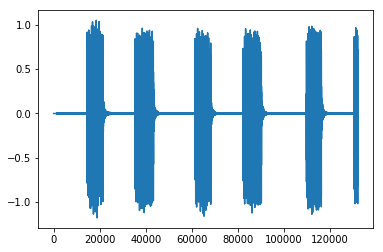

In [131]:
plt.plot(data)

In [132]:
# segment
results = dynamic_threshold_segmentation(
    data,
    rate,
    n_fft=n_fft,
    hop_length_ms=hop_length_ms,
    win_length_ms=win_length_ms,
    min_level_db_floor=min_level_db_floor,
    db_delta=db_delta,
    ref_level_db=ref_level_db,
    pre=pre,
    min_silence_for_spec=min_silence_for_spec,
    max_vocal_for_spec=max_vocal_for_spec,
    min_level_db=min_level_db,
    silence_threshold=silence_threshold,
    verbose=True,
    min_syllable_length_s=min_syllable_length_s,
    spectral_range=spectral_range,
)

longest silence 0.41999999999999993
longest vocalization 0.20700000000000007


In [133]:
results["onsets"]

array([0.33 , 0.803, 1.395, 1.869, 2.496])

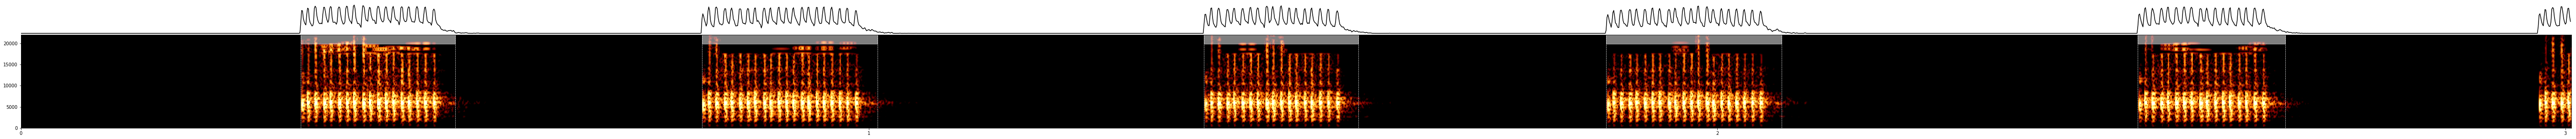

In [134]:
plot_segmentations(
    results["spec"],
    results["vocal_envelope"],
    results["onsets"],
    results["offsets"],
    hop_length_ms,
    rate,
    figsize=(100,5)
)
plt.show()

In [135]:
from avgn.utils.json import NoIndent, NoIndentEncoder

In [75]:
warnings.filterwarnings("ignore", message = "'tqdm_notebook' object has no attribute 'sp'")
def segment_spec_custom(key, df, save=False, plot=False):
    # load wav
    rate, data = load_wav(df.data["wav_loc"])
    # filter data
    data = butter_bandpass_filter(data, butter_min, butter_max, rate)

    # segment
    results = dynamic_threshold_segmentation(
        data,
        rate,
        n_fft=n_fft,
        hop_length_ms=hop_length_ms,
        win_length_ms=win_length_ms,
        min_level_db_floor=min_level_db_floor,
        db_delta=db_delta,
        ref_level_db=ref_level_db,
        pre=pre,
        min_silence_for_spec=min_silence_for_spec,
        max_vocal_for_spec=max_vocal_for_spec,
        min_level_db=min_level_db,
        silence_threshold=silence_threshold,
        verbose=True,
        min_syllable_length_s=min_syllable_length_s,
        spectral_range=spectral_range,
    )
    if results is None:
        print('skipping')
        return
    if plot:
        plot_segmentations(
            results["spec"],
            results["vocal_envelope"],
            results["onsets"],
            results["offsets"],
            hop_length_ms,
            rate,
        )
        plt.show()

    # save the results
    json_out = DATA_DIR / "processed" / (DATASET_ID + "_segmented") / DT_ID / "JSON" / (
        key + ".JSON"
    )
    print(json_out)

    json_dict = df.data.copy()

    json_dict["indvs"][list(df.data["indvs"].keys())[0]]["syllables"] = {
        "start_times": NoIndent(list(results["onsets"])),
        "end_times": NoIndent(list(results["offsets"])),
    }

    json_txt = json.dumps(json_dict, cls=NoIndentEncoder, indent=2)
    # save json
    if save:
        ensure_dir(json_out.as_posix())
        print(json_txt, file=open(json_out.as_posix(), "w"))

    #print(json_txt)

    return results

In [76]:
indvs = np.array(['_'.join(list(i)) for i in dataset.json_indv])
np.unique(indvs)[:10]

array(['89354', '89355', '89357', '89358', '89359', '89360', '89361',
       '89362', '89363', '89364'], dtype='<U5')

In [77]:
pd.DataFrame({indv:[np.sum(indvs == indv)] for indv in np.unique(indvs)})

,89354,89355,89357,89358,89359,89360,89361,89362,89363,89364,...,89577,89578,89579,89580,89581,89582,89583,89584,89585,89586
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


89354


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


/mnt/cube/tsainbur/Projects/github_repos/vocalization_segmentation/vocalseg/dynamic_thresholding.py:129: RuntimeWarning: invalid value encountered in sqrt
  vocal_envelope = np.max(spec, axis=0) * np.sqrt(np.mean(spec, axis=0))


longest silence 0.8689999999999998
longest vocalization 0.20700000000000074


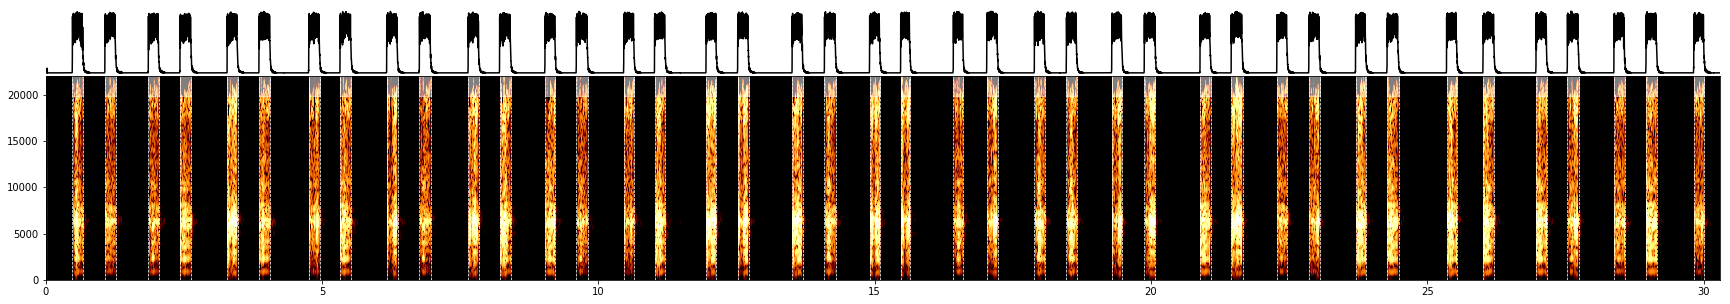

/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/Budka_crex_crex_segmented/2019-10-07_21-09-54/JSON/Crex_crex_89354_short.JSON
89355


longest silence 0.8439999999999994
longest vocalization 0.19899999999999984


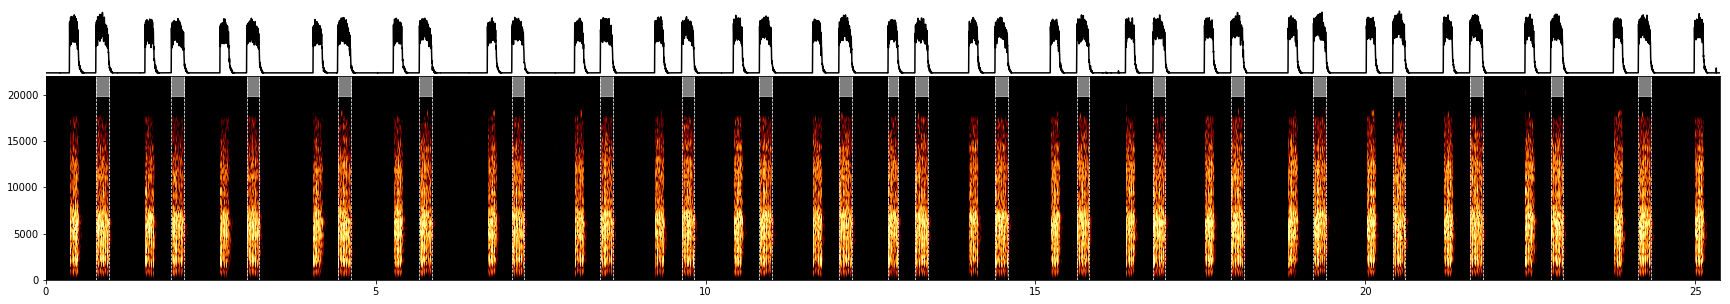

/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/Budka_crex_crex_segmented/2019-10-07_21-09-54/JSON/Crex_crex_89355_short.JSON
89357


longest silence 0.536999999999999
longest vocalization 0.21699999999999964


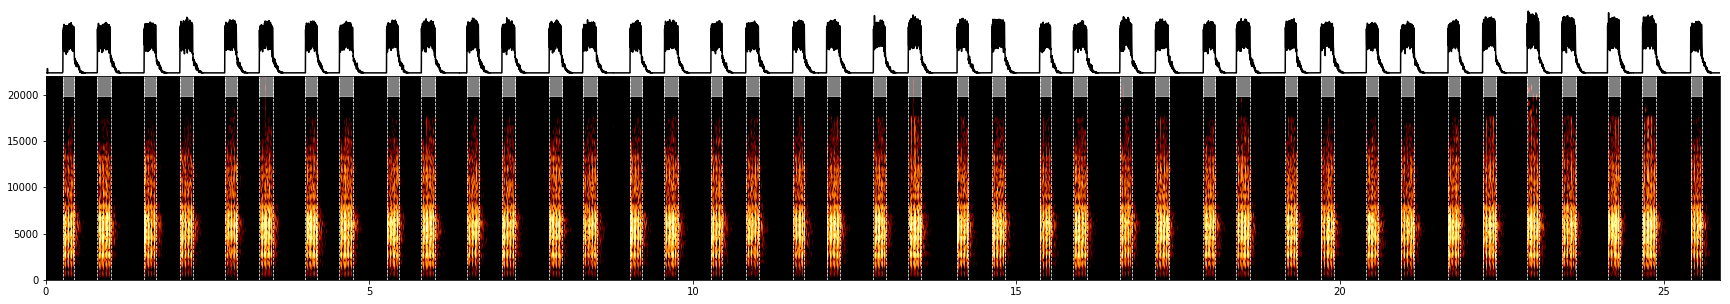

/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/Budka_crex_crex_segmented/2019-10-07_21-09-54/JSON/Crex_crex_89357_short.JSON
89358


longest silence 0.5179999999999971
longest vocalization 0.22299999999999898


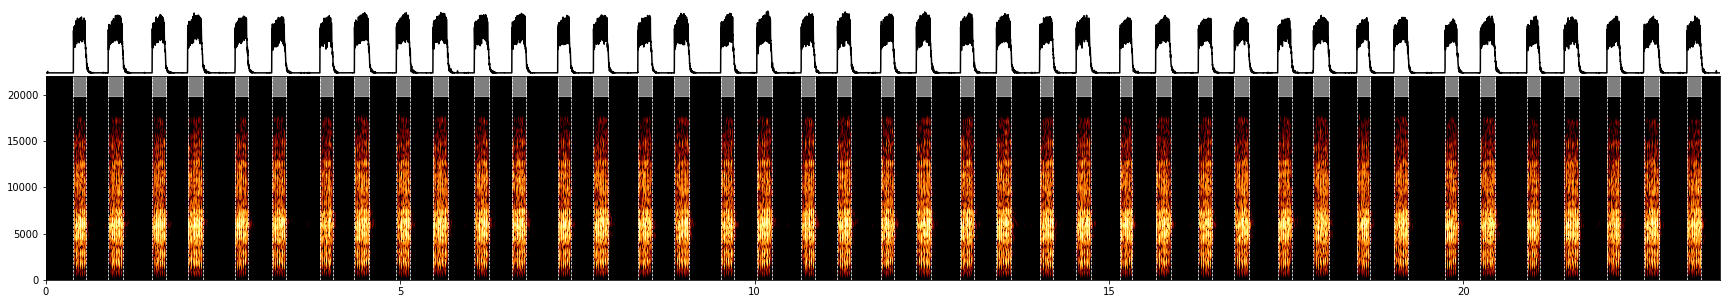

/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/Budka_crex_crex_segmented/2019-10-07_21-09-54/JSON/Crex_crex_89358_short.JSON
89359


longest silence 0.5240000000000009
longest vocalization 0.21300000000000008


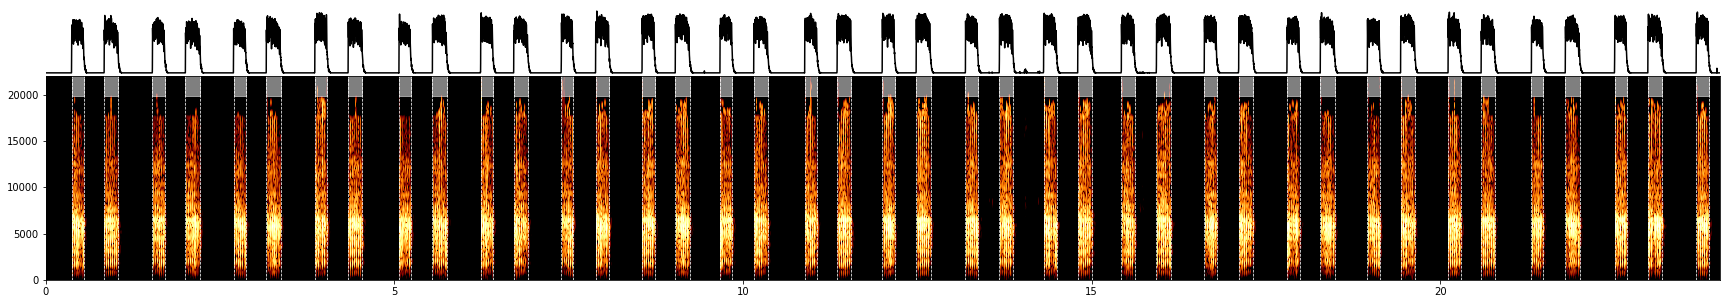

/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/Budka_crex_crex_segmented/2019-10-07_21-09-54/JSON/Crex_crex_89359_short.JSON
89360


longest silence 0.536999999999999
longest vocalization 0.20899999999999963


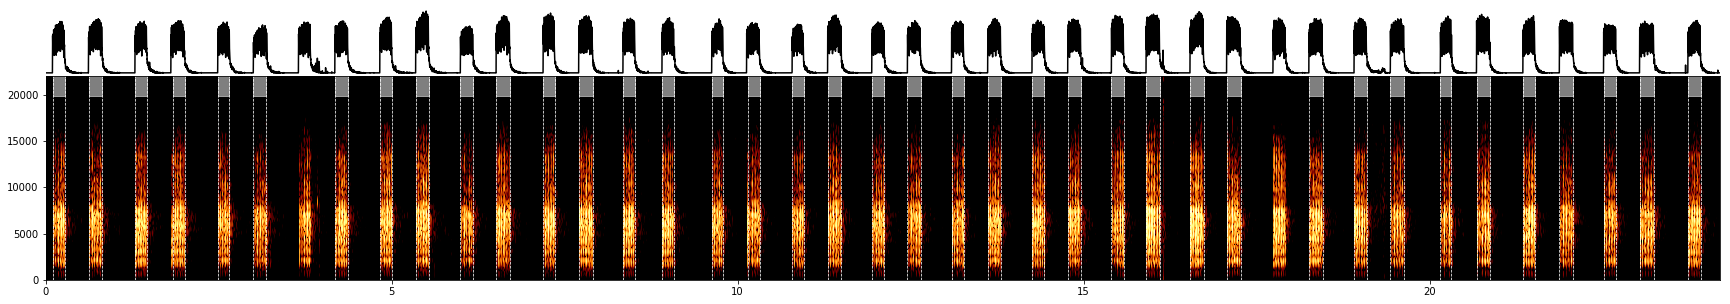

/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/Budka_crex_crex_segmented/2019-10-07_21-09-54/JSON/Crex_crex_89360_short.JSON
89361


longest silence 0.6300000000000026
longest vocalization 0.2270000000000003


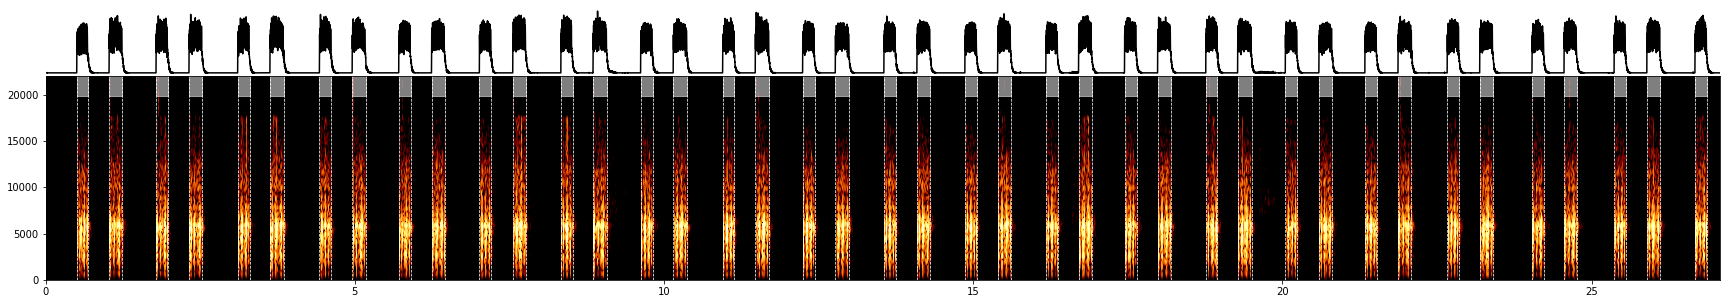

/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/Budka_crex_crex_segmented/2019-10-07_21-09-54/JSON/Crex_crex_89361_short.JSON
89362


longest silence 0.5070000000000014
longest vocalization 0.20800000000000196


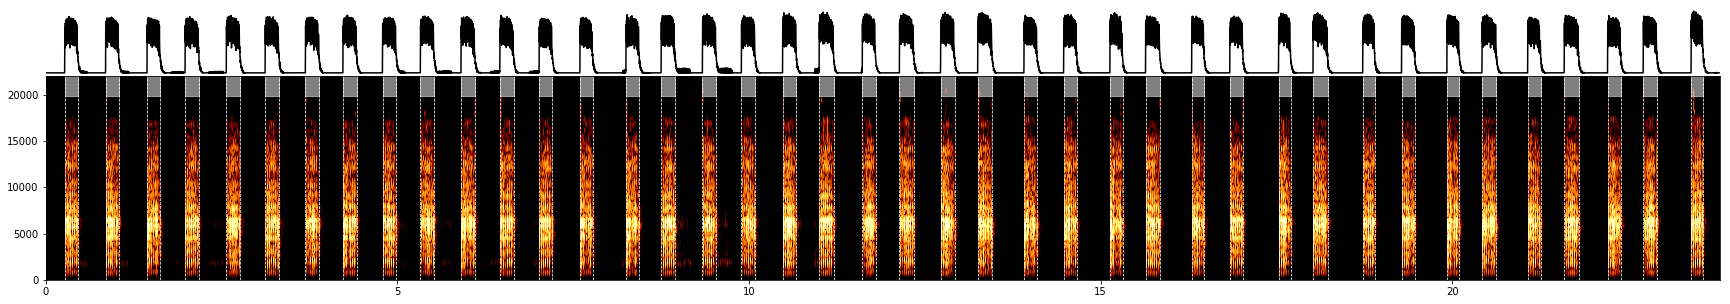

/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/Budka_crex_crex_segmented/2019-10-07_21-09-54/JSON/Crex_crex_89362_short.JSON
89363


longest silence 0.48799999999999955
longest vocalization 0.18399999999999928


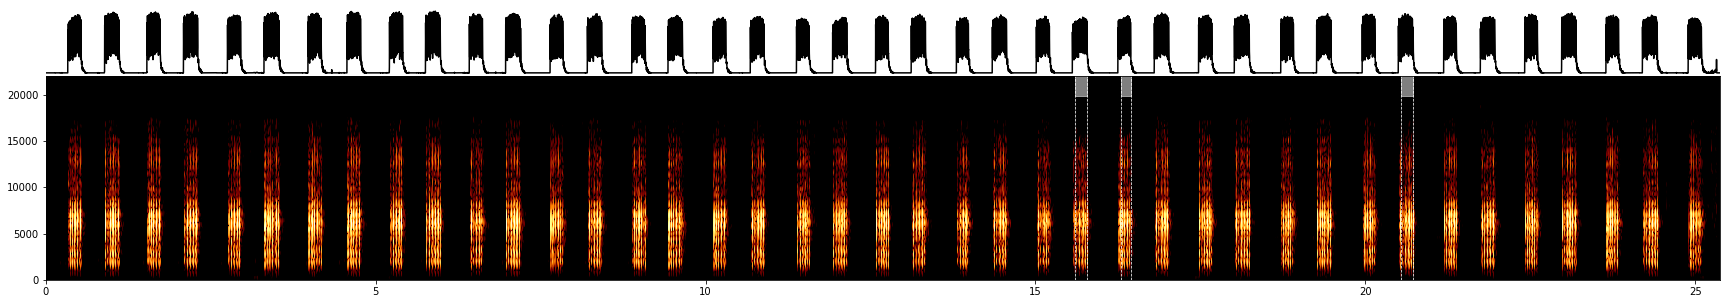

/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/Budka_crex_crex_segmented/2019-10-07_21-09-54/JSON/Crex_crex_89363_short.JSON
89364


longest silence 0.5909999999999997
longest vocalization 0.2270000000000003


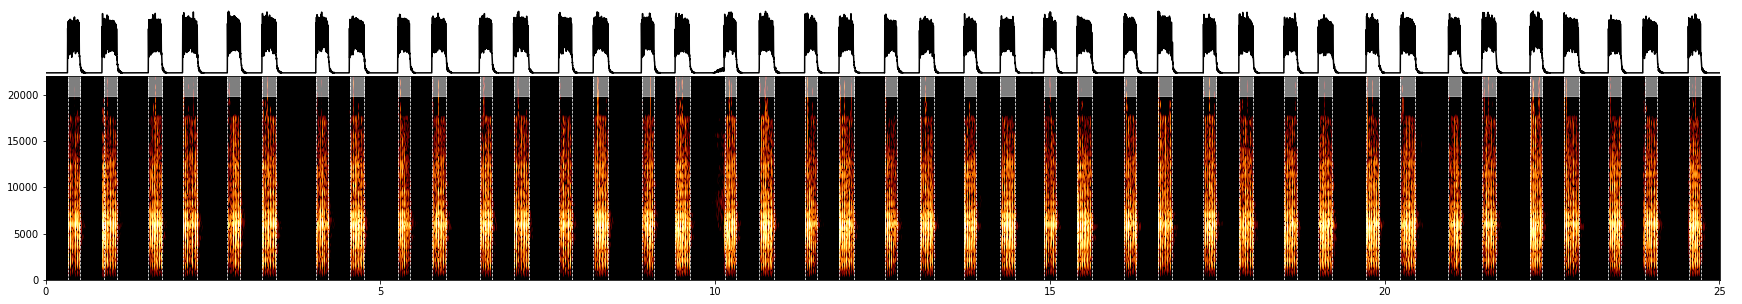

/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/Budka_crex_crex_segmented/2019-10-07_21-09-54/JSON/Crex_crex_89364_short.JSON


In [78]:
nex = 3
for indv in tqdm(np.unique(indvs)[:10], desc="individuals"):
    print(indv)
    indv_keys = np.array(list(dataset.data_files.keys()))[indvs == indv][:nex]

    joblib.Parallel(n_jobs=1, verbose=0)(
            joblib.delayed(segment_spec_custom)(key, dataset.data_files[key], plot=True) 
                 for key in tqdm(indv_keys, desc="files", leave=False)
        )

### Generate for full dataset

In [79]:
np.array(list(dataset.data_files.keys()))[indvs == indv][:nex]

array(['Crex_crex_89364_short'], dtype='<U21')

In [80]:
indv_keys = np.array(list(dataset.data_files.keys()))[indvs == indv][:nex]
indv_keys

array(['Crex_crex_89364_short'], dtype='<U21')

In [81]:
indv

'89364'

In [82]:
np.array(list(dataset.data_files.keys()))[indvs == indv][:nex]

array(['Crex_crex_89364_short'], dtype='<U21')

In [83]:
nex = -1
for indv in tqdm(np.unique(indvs), desc="individuals"):
    print(indv)
    indv_keys = np.array(list(dataset.data_files.keys()))[indvs == indv]

    joblib.Parallel(n_jobs=10, verbose=11)(
            joblib.delayed(segment_spec_custom)(key, dataset.data_files[key], save=True) 
                 for key in tqdm(indv_keys, desc="files", leave=False)
        )

89354


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89355


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:   25.1s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   25.1s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89357


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:   11.8s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   11.8s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89358


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:   12.3s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   12.3s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89359


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:   11.6s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   11.6s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89360


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:   11.0s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   11.0s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89361


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:   13.8s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   13.8s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89362


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:   11.2s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   11.2s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89363


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:   11.3s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   11.3s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89364


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    8.6s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    8.6s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89365


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:   10.3s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   10.3s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89366


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89367


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.6s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89368


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.6s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89369


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89370


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89371


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.2s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89372


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89373


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89374


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.8s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89375


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.2s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89376


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.2s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89377


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    2.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89378


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89379


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89380


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.3s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89381


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89382


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89383


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.7s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89384


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89385


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.2s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89386


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.8s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89387


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.7s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89388


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.7s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89389


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89390


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89391


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89392


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89393


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.6s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89394


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89395


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.8s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89396


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89397


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89398


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89399


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.6s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89400


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89401


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.7s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89402


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89403


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.6s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89404


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89405


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.7s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89406


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.9s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89407


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.7s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89408


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.8s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89409


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.6s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89410


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.6s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89411


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89412


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89413


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89414


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.3s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89415


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89416


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89417


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89418


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89419


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.3s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89420


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.3s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89421


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89422


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.2s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89423


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.7s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89424


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89425


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.7s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89426


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.2s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89427


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.2s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89428


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89429


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.6s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89430


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89431


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.1s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89432


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.3s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89433


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.2s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89434


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.3s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89435


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.3s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89436


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89437


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.2s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89438


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89439


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.3s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89440


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89441


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.9s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89442


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.2s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89443


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.2s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89444


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89445


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89446


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    2.3s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89447


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89448


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.6s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89449


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.3s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89450


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89451


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.2s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89452


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.6s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89453


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89454


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89455


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89456


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89457


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.7s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89458


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.6s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89459


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89460


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89461


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89462


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.6s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89463


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.3s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89464


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.7s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89465


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89466


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.6s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89467


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.8s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89468


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.6s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89469


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89470


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.6s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89471


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89472


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89473


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89474


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.9s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89475


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89476


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.3s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89477


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.3s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89478


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89479


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89480


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.6s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89481


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89482


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89483


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89484


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89485


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.1s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89486


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.3s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89487


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.7s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89488


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.3s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89489


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.2s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89490


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89491


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.2s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89492


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89493


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.3s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89494


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.2s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89495


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89496


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89497


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.8s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89498


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89499


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89500


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89501


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89502


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89503


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.3s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89504


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89505


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89506


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89507


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89508


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.3s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89509


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89510


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89511


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89512


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89513


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89514


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89515


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.6s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89516


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89517


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    2.0s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89518


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89519


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.6s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89520


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89521


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.6s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89522


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.6s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89523


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.7s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89524


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89525


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89526


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89527


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.3s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89528


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.8s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89529


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89530


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89531


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89532


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89533


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89534


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89535


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.7s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89536


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.6s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89537


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89538


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89539


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.8s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89540


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.6s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89541


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.6s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89542


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.7s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89543


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.8s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89544


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.6s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89545


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89546


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.6s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89547


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89548


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89549


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.3s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89550


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.0s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89551


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89552


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.3s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89553


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.2s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89554


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.2s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89555


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.3s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89556


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.2s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89557


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.1s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89558


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.1s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89559


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.2s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89560


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.9s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89561


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89562


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.2s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89563


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.1s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89564


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.2s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89565


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.2s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89566


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.2s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89567


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.2s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89568


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.1s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89569


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.3s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89570


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89571


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.7s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89572


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.2s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89573


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.1s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89574


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.3s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89575


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.2s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89576


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89577


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.2s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89578


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.0s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89579


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.1s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89580


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.2s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89581


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.6s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89582


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.1s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89583


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.1s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89584


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.7s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89585


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.2s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


89586


[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.2s finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    1.4s finished
